# <span style="color:coral"> <center> ConvNeXt on CIFAR 10</center> </span>

In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

# <span style="color:coral">Loading Cifar10 Data</span>

In [2]:
# importing Cifar10 data from keras datasets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Normalize train and test images
x_train, x_test = x_train / 255.0, x_test / 255.0 

170508288/170498071 [==============================] - 6s 0us/step


In [3]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE=128
# convert images to float32 format and convert labels to int32
def preprocess (image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.cast(label, tf.int32)
    return image, label

#Peform augmentations on training data
def augmentation(image,label):
    image = tf.image.resize_with_crop_or_pad(image, 40, 40) # Add 8 pixels of padding
    image = tf.image.random_crop(image, size=[32, 32, 3]) # Random crop back to 32x32
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.clip_by_value(image, 0., 1.)
    return image, label


train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#applying transformations 
train_data = train_data.shuffle(1024) # shuffle the images
train_data = train_data.map(preprocess, num_parallel_calls=AUTO)# mapping our preprocess function to train_data 
train_data = train_data.map(augmentation, num_parallel_calls=AUTO)# mapping our augmentation funtion to train_data
train_data = train_data.batch(BATCH_SIZE) #Converting train_data to batches
train_data = train_data.prefetch(AUTO) # using prefetch which prepares subsequent batches of data while other batches are being computed.


test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
#applying transformations 
test_data = test_data.map(preprocess, num_parallel_calls=AUTO) # mapping our preprocess function test_data 
test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.prefetch(AUTO) # using prefetch which prepares subsequent batches of data while other batches are being computed.


2022-11-25 20:37:37.641983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 20:37:37.730288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 20:37:37.731041: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 20:37:37.734193: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# <center>ConvNeXt Block</center>


 
As given in this paper we use a slightly modified inverted bottle-neck design given by:

1. A depthwise convolution, authors found out that `7x7 size` depthwise convolution gives better performance than that of other sizes. followed by a layer norm normalization layer as used in transformer architectures.

2. `Layer normalization` is used after the depthwise convolution instead of the Batch Normalization. As opposed to ResNet Block architecture ConvNeXt block only uses `layer norm` once in a residual block. 

> `Note:` In batchnorm, the mean and variance used for normalization are calculated across all elements in a batch, for each feature independently while in layernorm, they are calculated across the feature dimension, for each element and instance independently. 

3. A 1x1 `pointwise convolution` is used after LN.

4. A GELU activation function is used after 1x1 pointwise convolutional layer. As opposed to multiple ReLU activations in ResNet residual block, ConvNext uses GELU activation function only once in a residual block.

5. Another 1x1 `pointwise convolution` is used.


 

In [4]:
class ConvNext_Block(tf.keras.Model):
    
    """
    Implementing the ConvNeXt block for 
    
    Args:
        dim: No of input channels
        drop_path: stotchastic depth rate 
        layer_scale_init_value=1e-6
    
    Returns:
        A conv block
    """
    
    def __init__(self, dim, drop_path=0.0, layer_scale_init_value=1e-6, **kwargs):
        super(ConvNext_Block, self).__init__(**kwargs)
        
        self.depthwise_convolution = layers.Conv2D(dim, kernel_size=7, padding="same", groups=dim )
        self.layer_normalization = layers.LayerNormalization(epsilon=1e-6)
        self.pointwise_convolution_1 = layers.Dense(4 * dim)
        self.GELU = layers.Activation("gelu")
        self.pointwise_convolution_2 = layers.Dense(dim)
        self.gamma = tf.Variable(layer_scale_init_value * tf.ones((dim,)))
        if drop_path>0.0:
            self.drop_path=(tfa.layers.StochasticDepth(drop_path))
        else:
            self.drop_path=layers.Activation("linear")
        

    def call(self, inputs):
        x = inputs
        x = self.depthwise_convolution(x)
        x = self.layer_normalization(x)
        x = self.pointwise_convolution_1(x)
        x = self.GELU(x)
        x = self.pointwise_convolution_2(x)
        x = self.gamma * x

        return inputs + self.drop_path(x)


# Patchify Stem 



In [5]:
def patchify_stem(dims):
    """
    Implements the stem block of ConvNeXt
    
    Args:
        Dims: List of feature dimensions at each stage.
    
    Returns:
        feature maps after patchify operation
    """
    stem = keras.Sequential(
        [layers.Conv2D(dims[0], kernel_size=4, strides=4),
        layers.LayerNormalization(epsilon=1e-6)],
        )
    return stem

# Spatial Downsampling




In [6]:
def spatial_downsampling(stem,dims,kernel_size,stride):
    """
    Implements Spatial Downsampling of ConvNeXt
    
    Args:
        Dims: List of feature dimensions at each stage.
        stem: Patchify stem output of images
        kernel_size: Downsampling kernel_size
        stride: Downsampling stride length
    Returns:
        Downsampled layers
    """

    ds_layers = []
    ds_layers.append(stem)
    for dim in dims[1:]:
        layer = keras.Sequential(
            [layers.LayerNormalization(epsilon=1e-6),
            layers.Conv2D(dim, kernel_size=kernel_size, strides=stride),
            ]
        )
        ds_layers.append(layer)
        
    return ds_layers

# Convnext Stages


In [7]:
def ConvNext_Stages (dims,drop_path_rate,depths,layer_scale_init_value):
    """
    Creating stages each consiting of multiple residual blocks
    
    Args:
        dims: List of feature dimensions at each stage.
        drop_path_rate: Stochastic depth rate
        depths: Number of blocks at each stage
        layer_scale_init_value: Init value for Layer Scale
        
    """
    stages = []
    dropout_rates = [x for x in tf.linspace(0.0, drop_path_rate, sum(depths))]
    cur = 0
    for i in range(len(dims)):
        stage = keras.Sequential(
            [*[ConvNext_Block(dim=dims[i],drop_path=dropout_rates[cur + j],layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            ]
        )
        stages.append(stage)
        cur += depths[i]
    return stages

# Final ConvNeXt Model


In [8]:
drop_path_rate=0.0
layer_scale_init_value=1e-6
dims=[96, 192, 384, 768]
depths=[3, 3, 9, 3]

In [9]:
inputs = layers.Input((32,32,3))
x = inputs

stem=patchify_stem(dims)

downsampling=spatial_downsampling(stem,dims,kernel_size=2,stride=2)

stages=ConvNext_Stages(dims,drop_path_rate,depths,layer_scale_init_value)

for i in range(len(stages)):
    x = downsampling[i](x)
    x = stages[i](x)

x = layers.GlobalAvgPool2D()(x)
x = layers.LayerNormalization(epsilon=1e-6)(x)

outputs = layers.Dense(10)(x)

ConvNeXt_model=keras.Model(inputs, outputs)

In [10]:
ConvNeXt_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 8, 8, 96)          4896      
_________________________________________________________________
sequential_4 (Sequential)    (None, 8, 8, 96)          237888    
_________________________________________________________________
sequential_1 (Sequential)    (None, 4, 4, 192)         74112     
_________________________________________________________________
sequential_5 (Sequential)    (None, 4, 4, 192)         918144    
_________________________________________________________________
sequential_2 (Sequential)    (None, 2, 2, 384)         295680    
_________________________________________________________________
sequential_6 (Sequential)    (None, 2, 2, 384)         108172

In [11]:
ConvNeXt_model.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.001,weight_decay=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

history=ConvNeXt_model.fit(train_data,
          batch_size=64,
          epochs=25,
          validation_data=test_data)

2022-11-25 20:37:46.466036: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1228800000 exceeds 10% of free system memory.
2022-11-25 20:37:47.330679: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-25 20:37:47.394307: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1228800000 exceeds 10% of free system memory.


Epoch 1/25


2022-11-25 20:38:00.821970: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


391/391 [==============================] - 57s 98ms/step - loss: 2.2339 - accuracy: 0.2274 - val_loss: 1.7153 - val_accuracy: 0.3848


2022-11-25 20:38:45.609347: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1228800000 exceeds 10% of free system memory.


Epoch 2/25
391/391 [==============================] - 36s 91ms/step - loss: 1.7290 - accuracy: 0.3716 - val_loss: 1.6215 - val_accuracy: 0.4262
Epoch 3/25
391/391 [==============================] - 36s 91ms/step - loss: 1.5856 - accuracy: 0.4226 - val_loss: 1.4028 - val_accuracy: 0.4973
Epoch 4/25
391/391 [==============================] - 36s 91ms/step - loss: 1.4728 - accuracy: 0.4667 - val_loss: 1.3500 - val_accuracy: 0.5187
Epoch 5/25
391/391 [==============================] - 36s 93ms/step - loss: 1.4037 - accuracy: 0.4951 - val_loss: 1.2724 - val_accuracy: 0.5407
Epoch 6/25
391/391 [==============================] - 36s 91ms/step - loss: 1.3370 - accuracy: 0.5183 - val_loss: 1.2093 - val_accuracy: 0.5746
Epoch 7/25
391/391 [==============================] - 36s 92ms/step - loss: 1.2837 - accuracy: 0.5392 - val_loss: 1.1815 - val_accuracy: 0.5807
Epoch 8/25
391/391 [==============================] - 36s 92ms/step - loss: 1.2311 - accuracy: 0.5583 - val_loss: 1.0896 - val_accuracy:

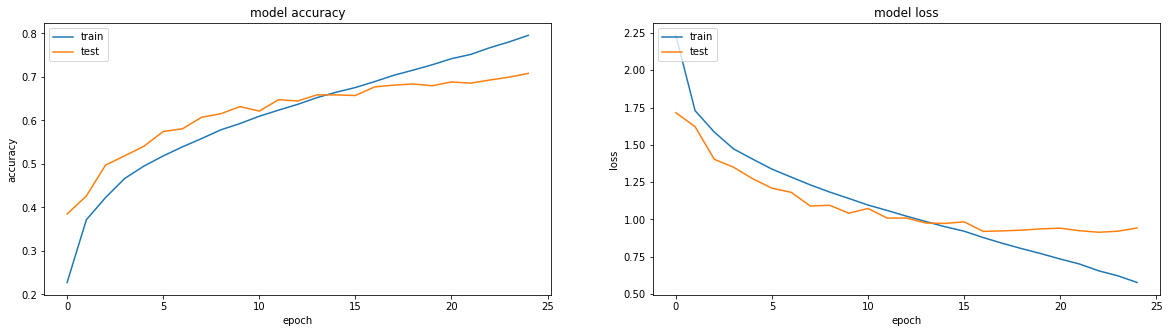

In [12]:
# Plotting loss and accuracy curves
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()